In [2]:
!pip install confluent-kafka

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 42.1 MB/s eta 0:00:00


In [3]:
import os
import cv2
import base64
import time
import json
import numpy as np

from google.colab import userdata
from confluent_kafka import Consumer
from google.colab.patches import cv2_imshow
from google.colab import auth
from google.cloud import aiplatform, storage
from google.protobuf import json_format
from google.protobuf.struct_pb2 import Value

In [5]:
auth.authenticate_user()

In [6]:
# Kafka Consumer Configuration
kafka_config = {
    'bootstrap.servers': "pkc-n3603.us-central1.gcp.confluent.cloud:9092",
    'sasl.username':     userdata.get('CONFLUENT_KEY'),
    'sasl.password':     userdata.get('CONFLUENT_SECRET'),
    'security.protocol': 'SASL_SSL',
    'sasl.mechanisms':   'PLAIN',
    'group.id':          'vertex-ai-consumer-group',
    'auto.offset.reset': 'latest' # Use 'latest' to process live data
}

In [7]:
# Google Cloud Configuration
PROJECT_ID = userdata.get('PROJECT_ID')
LOCATION = "us-central1"
ENDPOINT_ID = userdata.get('VERTEX_AI_ENDPOINT_ID')
BUCKET_NAME = "fire-detection-bucket-ds200"
PROCESSED_FRAMES_FOLDER = "processed_frames/"

In [8]:
# Prediction Confidence Threshold
CONFIDENCE_THRESHOLD = 0.5

In [9]:
# Initialize Google Cloud Storage Client
storage_client = storage.Client(project=PROJECT_ID)
bucket = storage_client.bucket(BUCKET_NAME)

In [10]:
# Initialize Vertex AI Prediction Client
api_endpoint = f"{LOCATION}-aiplatform.googleapis.com"
client_options = {"api_endpoint": api_endpoint}
prediction_client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)
endpoint_path = prediction_client.endpoint_path(project=PROJECT_ID, location=LOCATION, endpoint=ENDPOINT_ID)

In [16]:
# Initialize Kafka Consumer
consumer = Consumer(kafka_config)
topic = "test"
consumer.subscribe([topic])
print(f"Subscribed to topic: {topic}")

Subscribed to topic: test


In [17]:
def draw_boxes(image, predictions):
    """
    Draws bounding boxes on an image based on the Vertex AI model's output.
    """
    h, w, _ = image.shape
    prediction_list = []

    for prediction in predictions:
        # Convert protobuf struct to a Python dictionary
        prediction = dict(prediction)
        prediction_list.append(prediction) # Append dict for JSON export

        # Extract details for drawing
        confidences = prediction.get('scores', [])
        bboxes = prediction.get('boxes', [])
        display_names = prediction.get('classes', [])

        for i, box in enumerate(bboxes):
            if confidences[i] >= CONFIDENCE_THRESHOLD:
                # Vertex AI bboxes are in [xMin, xMax, yMin, yMax] format and normalized
                x1, x2, y1, y2 = box
                start_point = (int(x1 * w), int(y1 * h))
                end_point = (int(x2 * w), int(y2 * h))

                # Draw rectangle and label
                cv2.rectangle(image, start_point, end_point, (0, 255, 0), 2)
                label = f"{display_names[i]}: {confidences[i]:.2f}"
                cv2.putText(image, label, (start_point[0], start_point[1] - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image, prediction_list

Starting real-time processing loop...
Bounding boxes detected. Displaying and uploading image...
Uploaded processed image to processed_frames/frame_1752681657007.jpg


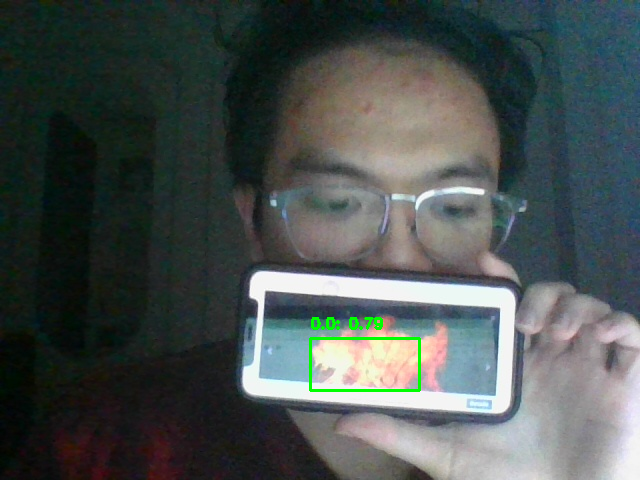

Bounding boxes detected. Displaying and uploading image...
Uploaded processed image to processed_frames/frame_1752681657474.jpg


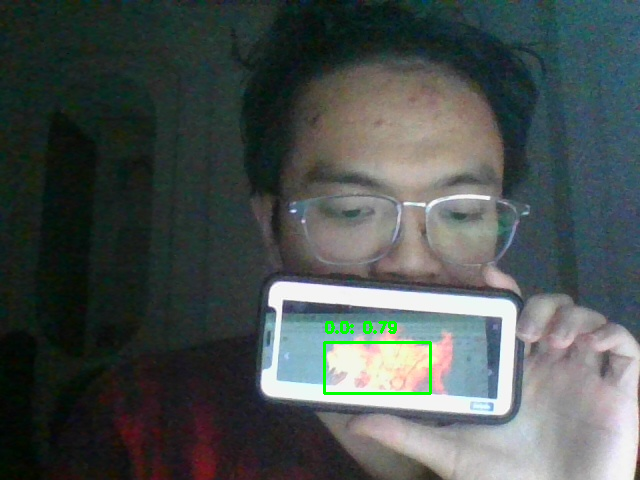

Flushing and closing Kafka consumer...
Cleanup complete.


KeyboardInterrupt: 

In [18]:
# --- Main Processing Loop (Final Version) ---
print("Starting real-time processing loop...")
try:
    latest_msg = None
    while True:
        # Poll for all waiting messages and only process the last one received
        while True:
            msg = consumer.poll(0)  # Non-blocking poll
            if msg is None:
                break
            if msg.error():
                print(f"ERROR: {msg.error()}")
                continue
            latest_msg = msg

        if latest_msg:
            # 1. Decode frame from Kafka message
            b64_decoded_frame = base64.b64decode(latest_msg.value())
            frame_buffer = np.frombuffer(b64_decoded_frame, np.uint8)
            frame = cv2.imdecode(frame_buffer, cv2.IMREAD_COLOR)

            if frame is None:
                print("Warning: Could not decode frame.")
                latest_msg = None
                continue

            # 2. Prepare frame for Vertex AI
            encoded_content = base64.b64encode(b64_decoded_frame).decode("utf-8")
            instance = json_format.ParseDict({"image_bytes": {"b64": encoded_content}}, Value())
            parameters = json_format.ParseDict({"confidenceThreshold": CONFIDENCE_THRESHOLD, "maxPredictions": 5}, Value())

            try:
                # 3. Send prediction request to Vertex AI
                response = prediction_client.predict(endpoint=endpoint_path, instances=[instance], parameters=parameters)

                # 4. Draw bounding boxes on the frame
                frame_with_boxes, predictions_json = draw_boxes(frame, response.predictions)

                # 5. Check if any bounding boxes were actually detected
                if predictions_json and any(p.get('boxes') for p in predictions_json):
                    print("Bounding boxes detected. Displaying and uploading image...")

                    # Generate a unique timestamp for the filename
                    timestamp = f"{int(time.time() * 1000)}"

                    # 5a. Save the processed image to GCS
                    is_success, buffer = cv2.imencode(".jpg", frame_with_boxes)
                    if is_success:
                        image_filename = f"{PROCESSED_FRAMES_FOLDER}frame_{timestamp}.jpg"
                        blob = bucket.blob(image_filename)
                        blob.upload_from_string(buffer.tobytes(), content_type='image/jpeg')
                        print(f"Uploaded processed image to {image_filename}")

                    # 5b. Display the resulting frame with boxes
                    cv2_imshow(frame_with_boxes)

            except Exception as e:
                print(f"An error occurred during processing: {e}")

            # Reset for the next iteration
            latest_msg = None

        # Check for 'q' key to exit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
finally:
    print("Flushing and closing Kafka consumer...")
    consumer.close()
    cv2.destroyAllWindows()
    print("Cleanup complete.")